<a href="https://colab.research.google.com/github/nahidmaleki/Classification-on-Various-Datasets/blob/main/LogisticRegression(Titanic_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan

- Load & peek

- Basic structure + missing overview

- Handle missing values, outliers, skewness

- Feature engineering + feature selection

- Encode categoricals → numericals (before split)

- Train/test split + class imbalance plot

- Min–Max scale (train-fit → test-transform)

- Train Logistic Regression

- Confusion matrix


In [50]:
# ============================================
# 🚢 Titanic — Simple Classification Demo
# ============================================

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')


# 1) Load dataset

In [51]:
titanic = sns.load_dataset('titanic')
type(titanic)


pandas.core.frame.DataFrame

# 2) Exploratory Data Review (EDR)

In [52]:
# Check rows, columns
titanic.shape


(891, 15)

In [53]:
# check dtypes + missing count
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [54]:
# check categorical summary
titanic.describe(include="object")


,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


In [55]:
# Check numeric summary
titanic.describe()


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [56]:
# Quick look at missing values
print("Missing values per columns:\n")
print(titanic.isnull().sum())


Missing values per columns:

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


## 3) missing values, outliers, skewness (compact, pragmatic) 🔡

**A quick compact visualization to spot:**

- Missing values → bar plot

- Outliers → boxplots

- Skewness → histograms

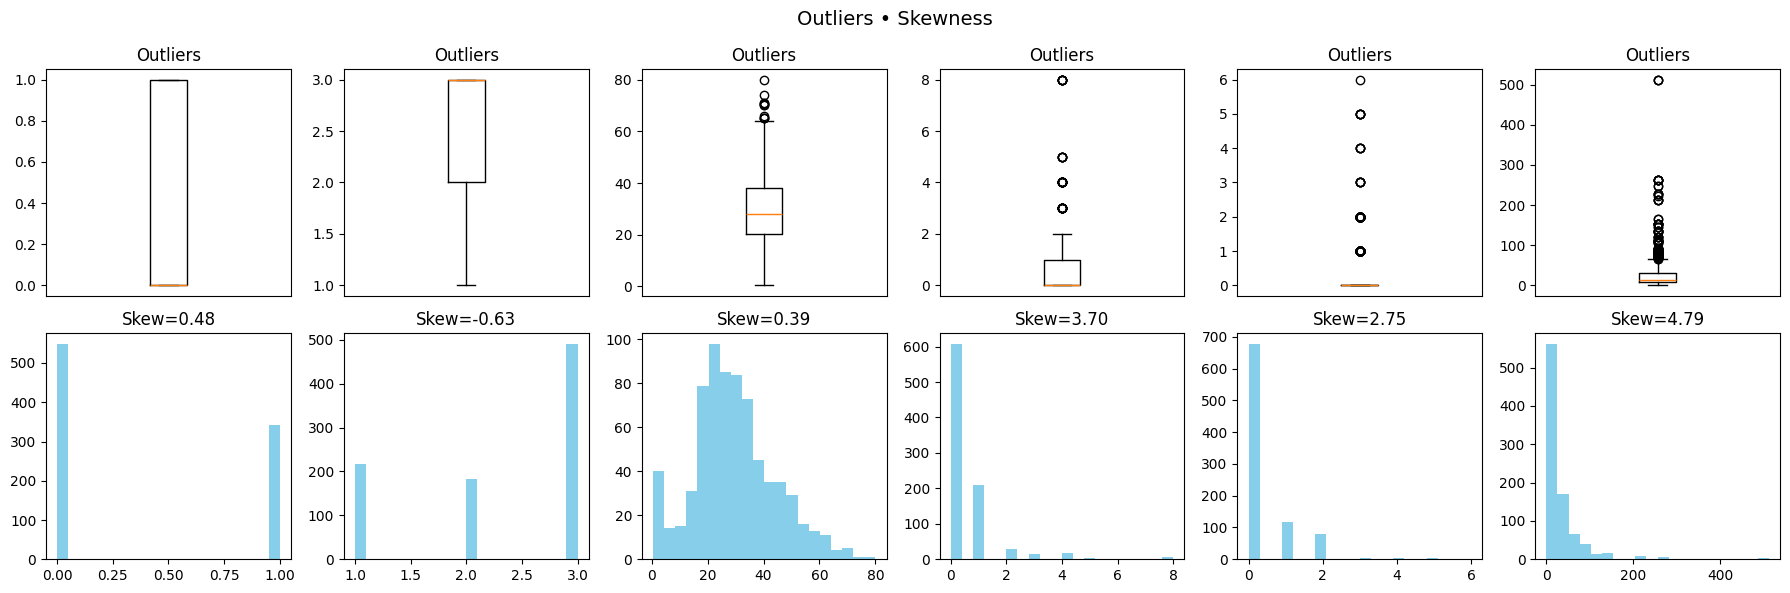

In [57]:
# Select all numeric columns from the Titanic dataset
num_cols = titanic.select_dtypes(include=np.number).columns

# Create the plot
fig, axes = plt.subplots(2, len(num_cols), figsize=(3*len(num_cols), 6))
fig.suptitle('Outliers • Skewness', fontsize=14)

for i, col in enumerate (num_cols):
  # Outliers (boxplot)
  axes[0, i].boxplot(titanic[col].dropna(), vert=True)
  axes[0, i].set_title("Outliers")
  axes[0, i].set_xticks([])

  # Skewness (histogram)
  axes[1, i].hist(titanic[col].dropna(), bins=20, color="skyblue")
  axes[1, i].set_title(f"Skew={titanic[col].dropna().skew():.2f}")

plt.tight_layout()
plt.show()


### Handle missing values, outliers, skewness (compact, pragmatic) 🔡

**Numeric:** median impute → IQR clip → log1p if |skew| > 1

**Categorical:** most frequent impute

In [58]:
# Split dtypes
num_cols_raw = titanic.select_dtypes(include=np.number).columns.tolist()
print("Numerical columns: ", num_cols_raw)
cat_cols_raw = titanic.select_dtypes(exclude=np.number).columns.tolist()
print("Categirical columns: ",cat_cols_raw)


Numerical columns:  ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
Categirical columns:  ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


In [59]:
# 3.1 Handling missing value
for c in num_cols_raw:
  titanic[c] = titanic[c].fillna(titanic[c].median())

for c in cat_cols_raw:
  titanic[c] = titanic[c].fillna(titanic[c].mode()[0])

# 3.2 Outliers (IQR clip) on numeric
for c in num_cols_raw:
  q1, q3 = titanic[c].quantile([0.25, 0.75])
  iqr = q3 - q1
  lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
  titanic[c] = titanic[c].clip(lo, hi)

# 3.3 Skewness (log1p if heavy)
for c in num_cols_raw:
  if abs(titanic[c].skew()) > 1:
    titanic[c] = np.log1p(titanic[c])


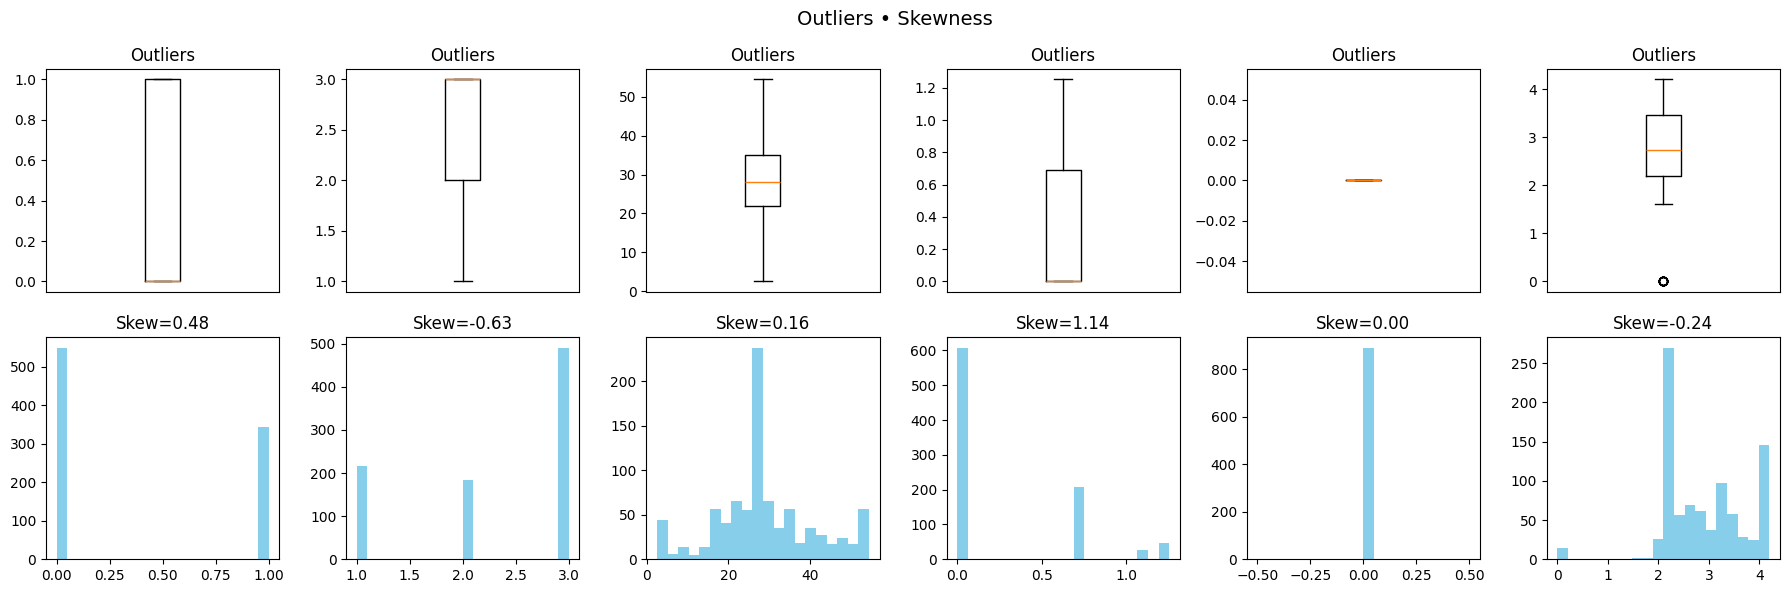

In [60]:
# Select all numeric columns from the Titanic dataset
num_cols = titanic.select_dtypes(include=np.number).columns

# Create the plot
fig, axes = plt.subplots(2, len(num_cols), figsize=(3*len(num_cols), 6))
fig.suptitle('Outliers • Skewness', fontsize=14)

for i, col in enumerate (num_cols):
  # Outliers (boxplot)
  axes[0, i].boxplot(titanic[col].dropna(), vert=True)
  axes[0, i].set_title("Outliers")
  axes[0, i].set_xticks([])

  # Skewness (histogram)
  axes[1, i].hist(titanic[col].dropna(), bins=20, color="skyblue")
  axes[1, i].set_title(f"Skew={titanic[col].dropna().skew():.2f}")

plt.tight_layout()
plt.show()


##  4. Correlation Analysis 📊

Correlation helps identify relationships between numerical features and survival outcome. Since Titanic has both categorical and numerical features, we’ll focus on numeric correlations with survived.

Correlation with survival: 
survived      1.000000
fare          0.321902
sibsp         0.063719
age          -0.060622
alone        -0.203367
pclass       -0.338481
adult_male   -0.557080
parch              NaN
Name: survived, dtype: float64


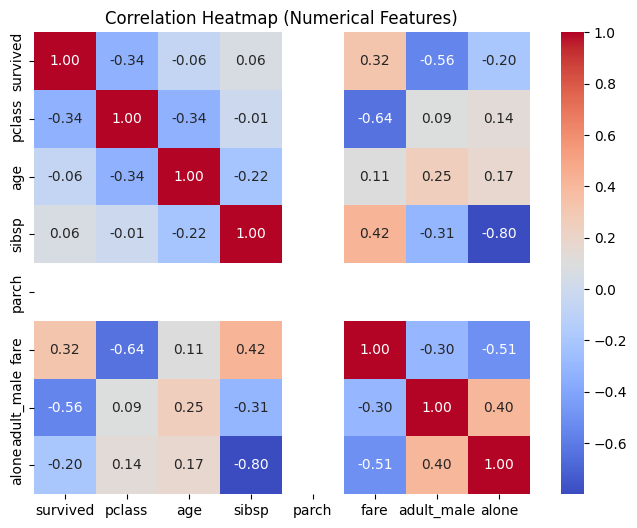

In [61]:
# Compute correlation matrix (numeric only)
corr = titanic.corr(numeric_only=True)

# Display correlation with target 'survived'
print("Correlation with survival: ")
print(corr['survived'].sort_values(ascending=False))

# Heatmap for numeric correlation
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


## 5) Feature engineering + feature selection

---



**Why drop:**

- *alive* → direct leakage of target

- *class* duplicates *pclass* (string vs. numeric)

- *embark_town* duplicates *embarked* (granularity overlap)

- *adult_male* & *who* are derivable from *sex*/*age*

- *alone* duplicates *(sibsp + parch == 0)*

- *deck* has very high missing originally; keep analysis simple → drop

**Also add:**

- *family_size = sibsp + parch + 1*

- *is_alone = (family_size == 1).astype(int)*

In [62]:
# Feature engineering
titanic["family_size"] = titanic["sibsp"] + titanic["parch"] + 1
titanic["is_alone"] = (titanic["family_size"] == 1).astype(int)

# Column to drop (leaky/redundant/high-missing)
drop_cols = [c for c in ["alive","class","embark_town","adult_male","who","alone","deck"] if c in titanic.columns]
titanic = titanic.drop(columns=drop_cols)

titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,family_size,is_alone
0,0,3,male,22.0,0.693147,0,2.110213,S,1.693147,0
1,1,1,female,38.0,0.693147,0,4.199221,C,1.693147,0
2,1,3,female,26.0,0.000000,0,2.188856,S,1.000000,1
3,1,1,female,35.0,0.693147,0,3.990834,S,1.693147,0
4,0,3,male,35.0,0.000000,0,2.202765,S,1.000000,1


## 6) Encode categoricals → numericals


In [63]:
# Identify columns again after selection
cat_cols = titanic.select_dtypes(exclude=np.number).columns.tolist()
num_cols = titanic.select_dtypes(include=np.number).columns.tolist()

df_ohe = titanic.copy()    # Keep a separate version
one_encoders = {}

ohe = OneHotEncoder(drop="first", sparse_output=False)  # Set sparse_output to False
encoded = ohe.fit_transform(df_ohe[cat_cols])

encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df_ohe.index)
df_ohe = pd.concat([df_ohe.drop(columns=cat_cols), encoded_df], axis=1)

df_ohe.head()


,survived,pclass,age,sibsp,parch,fare,family_size,is_alone,sex_male,embarked_Q,embarked_S
0,0,3,22.0,0.693147,0,2.110213,1.693147,0,1.0,0.0,1.0
1,1,1,38.0,0.693147,0,4.199221,1.693147,0,0.0,0.0,0.0
2,1,3,26.0,0.000000,0,2.188856,1.000000,1,0.0,0.0,1.0
3,1,1,35.0,0.693147,0,3.990834,1.693147,0,0.0,0.0,1.0
4,0,3,35.0,0.000000,0,2.202765,1.000000,1,1.0,0.0,1.0


# 7) Train–test split + class imbalance (counts + %)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify=y)


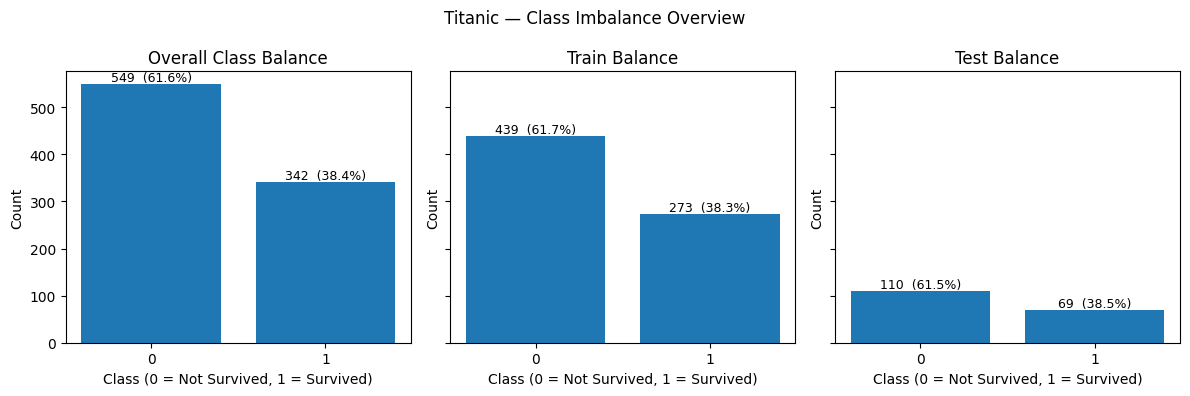

In [65]:
def plot_balance(ax, y, title):
    classes = [0, 1]
    counts = np.array([(y == c).sum() for c in classes])
    total = counts.sum()
    perc = counts / total * 100

    bars = ax.bar([str(c) for c in classes], counts)
    ax.set_title(title)
    ax.set_xlabel("Class (0 = Not Survived, 1 = Survived)")
    ax.set_ylabel("Count")

    # Add labels: count and percentage on top of bars
    for rect, c, p in zip(bars, counts, perc):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{c}  ({p:.1f}%)",
                ha="center", va="bottom", fontsize=9)

# Overall + Train/Test
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
plot_balance(axes[0], y, "Overall Class Balance")
plot_balance(axes[1], y_train, "Train Balance")
plot_balance(axes[2], y_test, "Test Balance")
fig.suptitle("Titanic — Class Imbalance Overview", fontsize=12)
plt.tight_layout()
plt.show()


# 8) Min–Max scale (fit on train, transform test) — numeric only

In [66]:
# Numeric cols in the current encoded frame are the original numeric ones
num_cols_to_scale = [c for c in num_cols if c in X_train.columns]

scaler = MinMaxScaler().fit(X_train[num_cols_to_scale])

X_train_s = X_train.copy()
X_test_s  = X_test.copy()

X_train_s[num_cols_to_scale] = scaler.transform(X_train[num_cols_to_scale])
X_test_s[num_cols_to_scale]  = scaler.transform(X_test[num_cols_to_scale])

# Sanity check
display(X_train_s[num_cols_to_scale].describe().T[["min","max"]].head())


,min,max
pclass,0.0,1.0
age,0.0,1.0
sibsp,0.0,1.0
parch,0.0,0.0
fare,0.0,1.0


# 9) Train Logistic Regression

In [67]:
logreg = LogisticRegression(max_iter=2000, n_jobs=None)  # n_jobs only for some solvers; keep default safe

logreg.fit(X_train_s, y_train)

# Predictions
y_pred  = logreg.predict(X_test_s)
y_proba = logreg.predict_proba(X_test_s)[:, 1]

pd.DataFrame({
    "y_pred": y_pred[:10],
    "P_survival": np.round(y_proba[:10], 3)
}, index=X_test_s.index[:10])



,y_pred,P_survival
565,0,0.069
160,0,0.063
553,0,0.143
860,0,0.036
241,1,0.706
559,0,0.491
387,1,0.712
536,0,0.317
698,0,0.410
99,0,0.193


# 10) Confusion Matrix & Visualization 📉

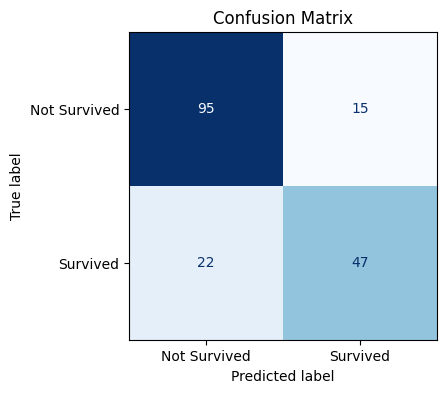

In [68]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived","Survived"])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()


# 11) Evaluation

In [71]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

